In [1]:
import qiskit as qk
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.circuit import Parameter
from qiskit.quantum_info.operators import Operator, Pauli

%matplotlib inline
import matplotlib.pyplot as plt

# Computational Problem

Here, we will consider minimizing the Ising Hamiltonian
\begin{equation}
H_C = \frac{1}{3}\sigma^z_1 - \frac{3}{4}\sigma^z_2 + \frac{5}{4}\sigma^z_1\sigma^z_2
\end{equation}

# QAOA Circuit

In [2]:
num_qubits = 2
qr = qk.QuantumRegister(num_qubits)
cr = qk.ClassicalRegister(num_qubits)

In [3]:
def state_prep():
    circ = qk.QuantumCircuit(qr, cr)
    circ.h(qr)
    return circ

Now, we wish to define the mixer evolution $U_M=e^{-i\beta H_M}$, where $H_M=\sum_i \sigma^x_i$. Note that $U_M$ is just a series of $R_x$ rotations; however, to get the angle or rotation correct, we must use $R_x(2\beta)$. This is because by definition $R_x(\theta)=e^{-i\frac{\theta}{2}\sigma^x}$.

In [4]:
def mixer(beta):
    circ = qk.QuantumCircuit(qr, cr)
    circ.rx(2*beta, qr)
    return circ

In [5]:
def cost(gamma):
    circ = qk.QuantumCircuit(qr, cr)
    circ.rz(2*gamma*1/3, qr[0]) # 1/3*sz_1
    circ.rz(2*gamma*3/4, qr[1]) # 3/4*sz_2
    # ZZ Interaction
    circ.cx(qr[0], qr[1])
    circ.rz(2*gamma*5/4, qr[1])
    circ.cx(qr[0], qr[1])
    return circ

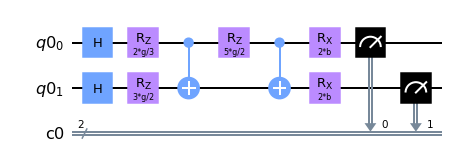

In [6]:
beta = Parameter('b')
gamma = Parameter('g')

qaoa_p1 = qk.QuantumCircuit(qr, cr)
qaoa_p1.compose(state_prep(), inplace=True)
qaoa_p1.compose(cost(gamma), inplace=True)
qaoa_p1.compose(mixer(beta), inplace=True)
qaoa_p1.measure(qr, cr)

qaoa_p1.draw('mpl', fold=-1)

## Implement Circuit

In [7]:
# Choose parameter values
beta_val = 3*np.pi/5
gamma_val = np.pi/2

# Set parameters in circuit
qaoa_p1_set = qaoa_p1.bind_parameters({beta: beta_val, gamma: gamma_val})

# Run simulation
shots = 8000
backend = Aer.get_backend('qasm_simulator')
job = qk.execute(qaoa_p1_set, backend=backend, shots=shots)
results = job.result()
counts = results.get_counts(qaoa_p1_set)

### Compute Expectation Value

In [8]:
def create_state_from_outcome(outcome):
    # Turns string of 0s and 1s into quantum state
    zero = np.array([[1],[0]])
    one = np.array([[0],[1]])
    
    state = np.array([[1]])
    for elem in outcome[::-1]: # reverse bit ordering to calculate state
        if elem == '0':
            state = np.kron(state, zero)
        else:
            state = np.kron(state, one)
    return state

In [9]:
def expectation_value(counts, shots, Hc):
    hc_matr = Hc.data # change to a numpy array
    exp_val = 0
    for outcome in counts.keys():
        state = create_state_from_outcome(outcome)
        prob = counts[outcome]/shots
        exp_val += prob*(state.conjugate().transpose() @ hc_matr @ state)
    return np.real(exp_val[0,0])

In [10]:
# The cost Hamiltonian
ZZ = Operator(Pauli(label='ZZ'))
Z1 = Operator(Pauli(label='ZI'))
Z2 = Operator(Pauli(label='IZ'))
H_c = 1/3*Z1 - 3/4*Z2 + 5/4*ZZ

In [11]:
expectation_value(counts, shots, H_c)

0.21841666666666665

### Examining Dependence on the Variational Parameters

In [12]:
shots = 8000
backend = Aer.get_backend('qasm_simulator')

# Set parameter ranges
beta_list = 2*np.pi*np.linspace(0,1,100)
gamma_list = np.pi*np.linspace(0,1,100)

# The cost Hamiltonian
ZZ = Operator(Pauli(label='ZZ'))
Z1 = Operator(Pauli(label='ZI'))
Z2 = Operator(Pauli(label='IZ'))
H_c = 1/3*Z1 - 3/4*Z2 + 5/4*ZZ

# Vary variational parameters
all_data = []
for beta_val in beta_list:
    gamma_data = []
    for gamma_val in gamma_list:
        print(r'b = %2.4f,  g = %2.4f' % (beta_val, gamma_val))

        # Set parameters in circuit
        qaoa_p1_set = qaoa_p1.bind_parameters({beta: beta_val, gamma: gamma_val})

        # Run simulation
        job = qk.execute(qaoa_p1_set, backend=backend, shots=shots)
        results = job.result()
        counts = results.get_counts(qaoa_p1_set)

        # Compute expectation value
        exp_val = expectation_value(counts, shots, H_c)
        
        # Append data to gamma list
        gamma_data.append(exp_val)
    
    # Append data to master list
    all_data.append(gamma_data)

b = 0.0000,  g = 0.0000
b = 0.0000,  g = 0.0317
b = 0.0000,  g = 0.0635
b = 0.0000,  g = 0.0952
b = 0.0000,  g = 0.1269
b = 0.0000,  g = 0.1587
b = 0.0000,  g = 0.1904
b = 0.0000,  g = 0.2221
b = 0.0000,  g = 0.2539
b = 0.0000,  g = 0.2856
b = 0.0000,  g = 0.3173
b = 0.0000,  g = 0.3491
b = 0.0000,  g = 0.3808
b = 0.0000,  g = 0.4125
b = 0.0000,  g = 0.4443
b = 0.0000,  g = 0.4760
b = 0.0000,  g = 0.5077
b = 0.0000,  g = 0.5395
b = 0.0000,  g = 0.5712
b = 0.0000,  g = 0.6029
b = 0.0000,  g = 0.6347
b = 0.0000,  g = 0.6664
b = 0.0000,  g = 0.6981
b = 0.0000,  g = 0.7299
b = 0.0000,  g = 0.7616
b = 0.0000,  g = 0.7933
b = 0.0000,  g = 0.8251
b = 0.0000,  g = 0.8568
b = 0.0000,  g = 0.8885
b = 0.0000,  g = 0.9203
b = 0.0000,  g = 0.9520
b = 0.0000,  g = 0.9837
b = 0.0000,  g = 1.0155
b = 0.0000,  g = 1.0472
b = 0.0000,  g = 1.0789
b = 0.0000,  g = 1.1107
b = 0.0000,  g = 1.1424
b = 0.0000,  g = 1.1741
b = 0.0000,  g = 1.2059
b = 0.0000,  g = 1.2376
b = 0.0000,  g = 1.2693
b = 0.0000,  g =

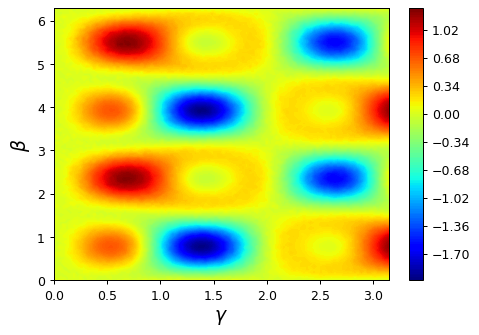

In [13]:
X, Y = np.meshgrid(gamma_list, beta_list)

fig = plt.figure(dpi=90)
ax = fig.add_subplot(111)
pl = ax.contourf(X, Y, all_data, levels=200, cmap='jet', vmin=np.min(all_data),
                vmax=np.max(all_data))

ax.set_ylabel(r'$\beta$', fontsize=15)
ax.set_xlabel(r'$\gamma$', fontsize=15)

fig.colorbar(pl)

### Finding Optimal Variational Parameters via Exhaustive Search

In [14]:
opt_val = np.max(all_data)
print('Best Solution: ', opt_val)

for i in range(len(all_data)):
    for j in range(len(all_data[i])):
        if all_data[i][j] == opt_val:
            opt_i = i
            opt_j = j
            break
opt_i, opt_j

Best Solution:  1.2737083333333334


(86, 22)

In [15]:
beta_list[opt_i], gamma_list[opt_j]

(5.458120569873176, 0.6981317007977319)

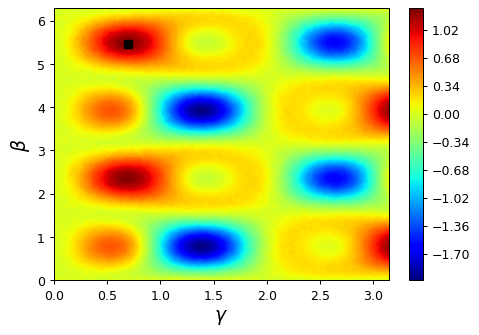

In [16]:
X, Y = np.meshgrid(gamma_list, beta_list)

fig = plt.figure(dpi=90)
ax = fig.add_subplot(111)
pl = ax.contourf(X, Y, all_data, levels=200, cmap='jet', vmin=np.min(all_data),
                vmax=np.max(all_data))

# Plot optimal value as black square
ax.plot(gamma_list[opt_j], beta_list[opt_i], 's', color='k')

ax.set_ylabel(r'$\beta$', fontsize=15)
ax.set_xlabel(r'$\gamma$', fontsize=15)

fig.colorbar(pl)